# AMLO Exploratory Data Analysis

In [4]:
import re
import os
import pandas as pd
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from amlo_parser import AMLOParser

#### CONSTANTS

In [7]:
PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/text_files/"
LABELED_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/amlo_labeling.xlsx"

#### Defining some classes and functions to help us with the analysis

In [3]:
# Use TF-IDF to find the most important words in the text
def get_most_important_words(text, filename, save=False):
    # Create a TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Apply the vectorizer
    tfidf_matrix = tfidf_vectorizer.fit_transform(text)

    # Print the result
    scores = tfidf_matrix.toarray()[0]
    words = tfidf_vectorizer.get_feature_names_out()

    # Create a DataFrame with the result
    df = pd.DataFrame({"Word": words, "Score": scores})
    df.sort_values("Score", ascending=False, inplace=True)

    if save:
        df.to_csv(filename, index=False)

    return df

### Pipeline

### Classification Task

In [8]:
# Read the labeled data
class TrainingSet:
    TRAINING_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/"
    LABELED_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/amlo_labeling.xlsx"
    TEXT_FILES_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/text_files/"
    DIALOGUES_PATH = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/presidents_dialogues/"

    def __init__(self, remove_stopwords):
        self.amlo_parser = AMLOParser(self.TEXT_FILES_PATH)
        self.path = LABELED_PATH
        self.labeled_data, self.agressive_phrases = self.read_labeled_data()
        self.remove_stopwords = remove_stopwords

        self.labeled_conference_ids = self.labeled_data["conference_id"].unique()
        self.all_files = os.listdir(self.TEXT_FILES_PATH)

    def read_labeled_data(self):
        """
        Reads the labeled data and agressive phrases from the excel file
        """
        labeled_data = pd.read_excel(self.path, sheet_name="labels")
        agressive_phrases = pd.read_excel(self.path, sheet_name="frases_odio")

        labeled_data = labeled_data.dropna()
        labeled_data.reset_index(drop=True, inplace=True)

        return labeled_data, agressive_phrases

    def agressive_phrases_to_txt(self, agressive_phrases, conference_id):
        """
        Parses the utterances from the dataframe and saves them to a txt file
        """
        # Save the agressive phrases to a txt file
        agressive_phrases_df = agressive_phrases.loc[
            agressive_phrases["conference_id"] == conference_id, :
        ]

        agressive_phrases_df.reset_index(drop=True, inplace=True)
        agressive_phrases_df = agressive_phrases_df.loc[:, ["phrase"]]

        # Write the text to a file
        new_file_path = os.path.join(self.TRAINING_PATH, f"{conference_id}.txt")
        new_file_path = new_file_path.replace(".txt", "_agressive_phrases.txt")

        with open(new_file_path, "w", encoding="utf-8") as f:
            for index, row in agressive_phrases_df.iterrows():
                phrase = self.amlo_parser.clean_text(
                    row["phrase"], remove_stopwords=self.remove_stopwords
                )
                f.write(phrase + "\n")

    def non_agressive_to_txt(self, conference_id):
        """
        Copies the non-agressive phrases to a txt file. Such phrases are under the
        president's dialogues folder
        """
        # Save the non-agressive phrases to a txt file
        print(f"Conference {conference_id} is not agressive")
        # Copy file to training data
        dialogue_path = os.path.join(
            self.DIALOGUES_PATH, f"{conference_id}_president_dialogues.txt"
        )

        with open(dialogue_path, "r", encoding="utf-8") as f:
            text = f.read()
            text = self.amlo_parser.clean_text(
                text, remove_stopwords=self.remove_stopwords
            )

        new_file_path = os.path.join(
            self.TRAINING_PATH, f"{conference_id}_non_agressive.txt"
        )

        with open(new_file_path, "w", encoding="utf-8") as f:
            f.write(text)

    def create_training_set(self):
        for file in tqdm(self.all_files):
            if file.endswith(".txt"):
                conference_id = int(re.findall(r"\d+", file)[0])

                if conference_id in self.labeled_conference_ids:
                    # Get conference label
                    conference_label = self.labeled_data.loc[
                        self.labeled_data["conference_id"] == conference_id,
                        "is_agressive",
                    ].values[0]

                    if conference_label == 1:
                        # Get the agressive phrases
                        self.agressive_phrases_to_txt(
                            self.agressive_phrases, conference_id
                        )
                    else:
                        # Copy the file to the training data
                        self.non_agressive_to_txt(conference_id)
                else:
                    continue

In [9]:
all_files = os.listdir(PATH)

training_set = TrainingSet(remove_stopwords=True)
training_set.create_training_set()

 21%|██▏       | 266/1241 [00:00<00:00, 2450.23it/s]

Conference 20181207 is not agressive
Conference 20190102 is not agressive
Conference 20190111 is not agressive
Conference 20190227 is not agressive
Conference 20200128 is not agressive
Conference 20210510 is not agressive


100%|██████████| 1241/1241 [00:00<00:00, 4295.63it/s]

Conference 20221125 is not agressive


### REGRESSION TASK

In [117]:
import os
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


from sklearn.preprocessing import MinMaxScaler


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

In [118]:
def create_classification_training_df(folder_path):
    """
    Creates a DataFrame with the training data for the classification model
    """

    # Initialize an empty list to store data
    data = []

    # Iterate through each file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            # Determine the label based on the file name
            label = 0 if "non" in file else 1
            id = int(re.findall(r"\d+", file)[0])
            # Read the text file
            with open(os.path.join(folder_path, file), "r", encoding="utf-8") as f:
                text = f.read()
            data.append({"id": id, "text": text, "label": label})

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)

    return df


In [147]:
def create_regression_training_df(folder_path, dialogues_path):
    """
    Creates a DataFrame with the training data for the classification model
    """

    # Initialize an empty list to store data
    data = []

    # Iterate through each file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            # Determine the label based on the file name
            label = 0 if "non" in file else 1
            id = int(re.findall(r"\d+", file)[0])
            # Read the text file
            with open(os.path.join(folder_path, file), "r", encoding="utf-8") as f:
                text = f.read()
            if label == 1:
                # Get text from president's dialogues
                with open(
                    os.path.join(dialogues_path, f"{id}_president_dialogues.txt"),
                    "r",
                    encoding="utf-8",
                ) as f:
                    dialogues = f.read()

                # Ratio of agressive phrases
                length_agressive = len(text.split())
                length_total = len(dialogues.split())

                ratio = length_agressive / length_total

                data.append({"id": id, "text": text, "score": ratio})

            else:
                continue

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)

    return df

In [148]:
def train_classification_model(df):
    """
    Trains a simple classification model using TF-IDF and logistic regression
    """
    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)

    # Fit and transform the 'text' column
    X = tfidf_vectorizer.fit_transform(df["text"])

    # Assuming 'label' is your target variable
    y = df["label"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=1000, class_weight="balanced")
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Print out the evaluation metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    return model, tfidf_vectorizer

In [149]:
def train_regression_model(df):
    """
    Trains a ridge regression model using the ratio of agressive phrases
    """

    tfidf_vectorizer = TfidfVectorizer(max_features=1000)

    # Fit and transform the 'text' column
    X = tfidf_vectorizer.fit_transform(df["text"])

    # Assuming 'label' is your target variable
    y = df["score"]

    # Assuming `X` is your matrix of embeddings and `y` is your vector of normalized aggressivity scores
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train the Ridge Regression model
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    return model, tfidf_vectorizer

In [159]:
def train_xgboost(df):
    """
    Trains an XGBoost model to predict
    the score of agressivity
    """

    # Import the XGBoost library
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)

    # Fit and transform the 'text' column
    X = tfidf_vectorizer.fit_transform(df["text"])

    # Assuming 'label' is your target variable
    y = df["score"]

    # Assuming `X` is your matrix of embeddings and `y` is your vector of normalized aggressivity scores
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Create the DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define the parameters
    param = {
        "max_depth": 8,
        "eta": 0.15,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
    }

    # Train the model
    num_round = 250
    bst = xgb.train(param, dtrain, num_round)

    # Make predictions
    y_pred = bst.predict(dtest)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    return bst, tfidf_vectorizer


In [160]:
def create_unseen_df(training_set):
    # Now, let us do it for the entire dataset
    data = []

    # Iterate through each file in the folder
    for file in os.listdir(training_set.DIALOGUES_PATH):
        if file.endswith(".txt"):
            # Determine the label based on the file name
            conference_id = int(re.findall(r"\d+", file)[0])

            if conference_id not in training_set.labeled_conference_ids:
                # Read the text file
                with open(
                    os.path.join(training_set.DIALOGUES_PATH, file),
                    "r",
                    encoding="utf-8",
                ) as f:
                    text = f.read()
                    data.append({"id": conference_id, "text": text})

    unseen_df = pd.DataFrame(data)

    return unseen_df

In [161]:
def predict_unseen_data(model, unseen_df, tfidf_vectorizer, regression=False):
    """
    Predicts the labels for the unseen data
    """
    # Fit and transform the 'text' column
    X_unseen = tfidf_vectorizer.fit_transform(unseen_df["text"])

    # Make predictions on the unseen data
    y_unseen = model.predict(X_unseen)

    # Add the predictions to the DataFrame
    if regression:
        unseen_df["score"] = y_unseen
    else:
        unseen_df["label"] = y_unseen

    return unseen_df


In [162]:
def predict_xgboost(model, unseen_df, tfidf_vectorizer):
    """
    Predicts the labels for the unseen data
    """
    # Fit and transform the 'text' column
    X_unseen = tfidf_vectorizer.fit_transform(unseen_df["text"])

    # Create the DMatrix
    d_unseen = xgb.DMatrix(X_unseen)

    # Make predictions
    y_unseen = model.predict(d_unseen)

    # Add the predictions to the DataFrame
    unseen_df["score"] = y_unseen

    return unseen_df

#### MODELING PIPELINE

In [163]:
# Specify the path to your training data folder
folder_path = "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/"

# Create the training DataFrame
df = create_classification_training_df(folder_path)

# Train the classification model
model, tfidf_vectorizer = train_classification_model(df)

# Create the unseen data DataFrame
unseen_df = create_unseen_df(training_set)

# Predict the labels for the unseen data
results_df = predict_unseen_data(model, unseen_df, tfidf_vectorizer)


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         5

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [ ]:
regression_training_df = create_regression_training_df(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/",
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/presidents_dialogues/",
)

ridge_model, tfidf_vectorizer = train_regression_model(regression_training_df)

# NORMALIZE THE SCOR
unseen_reg_df = create_unseen_df(training_set)

# Predict the labels for the unseen data
unseen_reg_df = predict_unseen_data(
    ridge_model, unseen_reg_df, tfidf_vectorizer, regression=True
)

complete_df = pd.concat([regression_training_df, unseen_reg_df], ignore_index=True)

scaler = MinMaxScaler()

# Normalize the score
scores = np.array(complete_df["score"]).reshape(-1, 1)

scaler.fit(scores)

complete_df["score"] = scaler.transform(scores)


Mean Squared Error: 0.0015495495757083364
R^2 Score: 0.29136016074008164


In [ ]:
complete_df.head()

,id,text,score
0,20190325,"existe prensa fifi, invención, existe partido ...",0.010673
1,20190430,jesús explicaba significado política neolibera...,0.320800
2,20191218,otras organizaciones supuestamente independien...,0.000000
3,20200113,política educativa estaba orientada dejar merc...,0.147494
4,20201125,"sí, bueno, general decirles toda violencia pad...",0.408059


In [ ]:
# Train the XGBoost model

training_df = create_regression_training_df(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/training_data/",
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/presidents_dialogues/",
)

xgboost_model, tfidf_vectorizer = train_xgboost(training_df)

# Create the unseen data DataFrame
unseen_df = create_unseen_df(training_set)

# Predict the labels for the unseen data
results_df = predict_xgboost(xgboost_model, unseen_df, tfidf_vectorizer)

# Concat the results and the training data

complete_df = pd.concat([training_df, results_df], ignore_index=True)

scaler = MinMaxScaler()

# Normalize the score
scores = np.array(complete_df["score"]).reshape(-1, 1)

scaler.fit(scores)

complete_df["score"] = scaler.transform(scores)

complete_df.head()

# Save the results to a CSV file

# Add a column with the length of the text

complete_df["num_words"] = complete_df["text"].apply(lambda x: len(x.split()))

complete_df.to_csv(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/xgb_agressivity_scores.csv", index=False
)

Mean Squared Error: 0.0022870911278964037
R^2 Score: -0.04593225970483772


In [ ]:
# Remove text column
complete_df = complete_df.drop("text", axis=1)

# Save the results to a CSV file
complete_df.to_csv(
    "C:/Users/fdmol/Desktop/AMLO-NLP/src/data/xgb_agressivity_scores_no_words.csv",
    index=False,
)


PermissionError: [Errno 13] Permission denied: 'C:/Users/fdmol/Desktop/AMLO-NLP/src/data/xgb_agressivity_scores_no_words.csv'

Text(0.5, 1.0, 'Distribution of Aggressivity Scores')

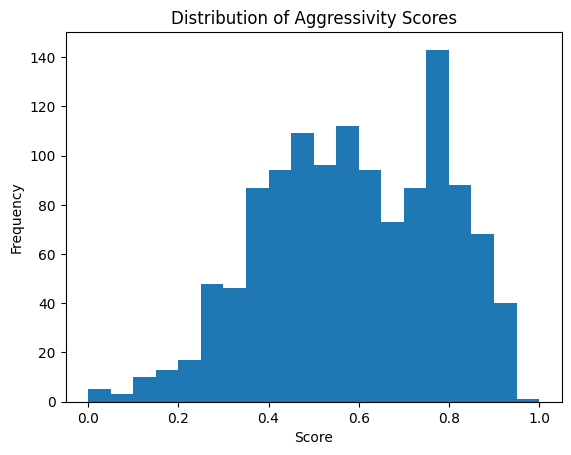

In [ ]:
# Plot histogram of the scores

import matplotlib.pyplot as plt

plt.hist(complete_df["score"], bins=20)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Aggressivity Scores")


### Possible models to use:

Summarization:

https://huggingface.co/mrm8488/bert2bert_shared-spanish-finetuned-summarization


Sentiment Analysis:

https://huggingface.co/finiteautomata/beto-sentiment-analysis


Emotion Analysis:

https://huggingface.co/finiteautomata/beto-emotion-analysis
